In [111]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf


In [83]:
data = yf.download("TSLA" , start = "2015-01-01", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [84]:
data.shape

(1861, 6)

In [85]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,44.574001,44.650002,42.652000,43.862000,43.862000,23822000
2015-01-05,42.910000,43.299999,41.431999,42.018002,42.018002,26842500
2015-01-06,42.012001,42.840000,40.841999,42.256001,42.256001,31309500
2015-01-07,42.669998,42.956001,41.956001,42.189999,42.189999,14842000
2015-01-08,42.562000,42.759998,42.001999,42.124001,42.124001,17212500


Understanding Trends with in the Data

In [86]:
# Sort the data points based on indexes just for confirmation 
data.sort_index(inplace = True)

In [87]:

# Remove any duplicate index 
data = data.loc[~data.index.duplicated(keep='first')]

In [88]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-17,747.359985,764.479980,728.849976,761.609985,761.609985,26745400
2022-05-18,744.520020,760.500000,700.809998,709.809998,709.809998,29270600
2022-05-19,707.000000,734.000000,694.109985,709.419983,709.419983,30098900
2022-05-20,713.989990,721.580017,633.000000,663.900024,663.900024,48190600
2022-05-23,655.020020,679.955078,638.059998,669.489990,669.489990,26294936


In [89]:
# Check for missing values 
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [90]:
# Get the statistics of the data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1861.000000,1861.000000,1861.000000,1861.000000,1861.000000,1.861000e+03
mean,230.130272,235.251374,224.448718,229.999784,229.999784,3.771046e+07
std,310.180200,317.340558,301.933835,309.731450,309.731450,2.757618e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,3.540000e+06
25%,47.257999,48.000000,46.521999,47.518002,47.518002,2.094290e+07
50%,62.959999,63.799999,61.902000,63.046001,63.046001,2.924250e+07
75%,294.000000,302.648010,284.196014,297.000000,297.000000,4.339100e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [91]:
import plotly.graph_objects as go

# Check the trend in Closing Values 
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Close'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900, 
                  xaxis_title='Date' , yaxis_title='Close')
fig.show()

In [92]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Volume'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900, 
                  xaxis_title='Date' , yaxis_title='Volume')
fig.show()

Data Preparation

In [93]:
from sklearn.preprocessing import MinMaxScaler 
import pickle 
from tqdm.notebook import tnrange

In [94]:
# Filter only required data 
data = data[['Close' , 'Volume']]
data.head(5)

,Close,Volume
Date,,
2015-01-02,43.862000,23822000
2015-01-05,42.018002,26842500
2015-01-06,42.256001,31309500
2015-01-07,42.189999,14842000
2015-01-08,42.124001,17212500


In [95]:
# Confirm the Testing Set length 
test_length = data[(data.index >= '2020-09-01')].shape[0]

In [96]:
def CreateFeatures_and_Targets(data, feature_length):
    X = []
    Y = []

    for i in tnrange(len(data) - feature_length): 
        X.append(data.iloc[i : i + feature_length,:].values)
        Y.append(data["Close"].values[i+feature_length])

    X = np.array(X)
    Y = np.array(Y)

    return X , Y

In [97]:
X , Y = CreateFeatures_and_Targets(data , 32)

  0%|          | 0/1829 [00:00<?, ?it/s]

In [98]:
# Check the shapes
X.shape , Y.shape

((1829, 32, 2), (1829,))

In [99]:
Xtrain , Xtest , Ytrain , Ytest = X[:-test_length] , X[-test_length:] , Y[:-test_length] , Y[-test_length:]

In [100]:
# Check Training Dataset Shape 
Xtrain.shape , Ytrain.shape

((1394, 32, 2), (1394,))

In [101]:
# Check Testing Dataset Shape
Xtest.shape , Ytest.shape

((435, 32, 2), (435,))

In [102]:
# Create a Scaler to Scale Vectors with Multiple Dimensions 
class MultiDimensionScaler():
    def __init__(self):
        self.scalers = []

    def fit_transform(self , X):
        total_dims = X.shape[2]
        for i in range(total_dims):
            Scaler = MinMaxScaler()
            X[:, :, i] = Scaler.fit_transform(X[:, :, i])
            self.scalers.append(Scaler)
        return X

    def transform(self , X):
        for i in range(X.shape[2]):
            X[:, :, i] = self.scalers[i].transform(X[:,:,i])
        return X 

In [103]:
Feature_Scaler = MultiDimensionScaler()
Xtrain = Feature_Scaler.fit_transform(Xtrain)
Xtest = Feature_Scaler.transform(Xtest)

In [104]:
Target_Scaler = MinMaxScaler()
Ytrain = Target_Scaler.fit_transform(Ytrain.reshape(-1,1))
Ytest = Target_Scaler.transform(Ytest.reshape(-1,1))

In [105]:
def save_object(obj , name : str):
    pickle_out = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()

def load_object(name : str):
    pickle_in = open(f"{name}.pck","rb")
    data = pickle.load(pickle_in)
    return data

In [106]:
# Save your objects for future purposes 
save_object(Feature_Scaler , "Feature_Scaler")
save_object(Target_Scaler , "Target_Scaler")

Model Building

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

save_best = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=4, min_lr=0.00001,verbose = 1)

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional

model = Sequential()

model.add(Bidirectional(LSTM(512 ,return_sequences=True , recurrent_dropout=0.1, input_shape=(32, 2))))
model.add(LSTM(256 ,recurrent_dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(64 , activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(32 , activation='elu'))
model.add(Dense(1 , activation='linear'))

2022-05-23 19:29:03.137 WARNING tensorflow: Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:29:03.148 WARNING tensorflow: Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:29:03.161 WARNING tensorflow: Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:29:03.171 WARNING tensorflow: Layer lstm_5 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [109]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.002)
model.compile(loss='mse', optimizer=optimizer)

In [59]:
history = model.fit(Xtrain, Ytrain,
            epochs=10,
            batch_size = 1,
            verbose=1,
            shuffle=False ,
            validation_data=(Xtest , Ytest),
            callbacks=[reduce_lr , save_best])

Epoch 1/10
1394/1394 [==============================] - 204s 144ms/step - loss: 0.0017 - val_loss: 0.6715 - lr: 0.0020
Epoch 2/10
1394/1394 [==============================] - 196s 141ms/step - loss: 0.0037 - val_loss: 0.4627 - lr: 0.0020
Epoch 3/10
1394/1394 [==============================] - 196s 141ms/step - loss: 0.0027 - val_loss: 0.2816 - lr: 0.0020
Epoch 4/10
1394/1394 [==============================] - 196s 141ms/step - loss: 0.0020 - val_loss: 0.2014 - lr: 0.0020
Epoch 5/10
1394/1394 [==============================] - 196s 141ms/step - loss: 0.0017 - val_loss: 0.1260 - lr: 0.0020
Epoch 6/10
1394/1394 [==============================] - 196s 141ms/step - loss: 0.0014 - val_loss: 0.0876 - lr: 0.0020
Epoch 7/10
1394/1394 [==============================] - 197s 141ms/step - loss: 0.0012 - val_loss: 0.0551 - lr: 0.0020
Epoch 8/10
1394/1394 [==============================] - 196s 141ms/step - loss: 9.3835e-04 - val_loss: 0.0405 - lr: 0.0020
Epoch 9/10
1394/1394 [======================

In [60]:
#accuracy = (X=Xtest,Y=Ytest,batch_size=32)
#print("Accuracy: ",accuracy[1])

Train And Test Score

In [61]:
trainScore = model.evaluate(Xtrain, Ytrain, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, (trainScore)))

testScore = model.evaluate(Xtest, Ytest, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, (testScore)))

Train Score: 0.00163206 MSE (0.00163206 RMSE)
Test Score: 0.04109967 MSE (0.04109967 RMSE)


In [62]:
# Checking the model Structure 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 32, 1024)         2109440   
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 256)               1311744   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [63]:
# Load the best weights
model.load_weights("best_weights.h5")

Visualize prediction on Test Set

In [64]:
Predictions = model.predict(Xtest)

In [65]:
Predictions = Target_Scaler.inverse_transform(Predictions)
Actual = Target_Scaler.inverse_transform(Ytest)

In [66]:
Predictions = np.squeeze(Predictions , axis = 1)
Actual = np.squeeze(Actual , axis = 1)

In [67]:
# Creating Sample Test Dataframe
test_dataframe_dict = {'Actual' : list(Actual) , 'Predicted' : list(Predictions)}
test_df = pd.DataFrame.from_dict(test_dataframe_dict)

#test_df.index = data.index[-test_length:]

In [68]:
test_df.head()

,Actual,Predicted
0,475.049988,442.852905
1,447.369995,452.906494
2,407.000000,460.475342
3,418.320007,464.581696
4,330.209991,468.382111


In [69]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = test_df.index , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = test_df.index , y = Predictions , mode = 'lines' , name='Predicted'))
fig.show()

Visualize Prediction on whole data

In [70]:
Total_features = np.concatenate((Xtrain , Xtest) , axis = 0)

In [71]:
Total_Targets = np.concatenate((Ytrain , Ytest) , axis = 0)

In [72]:
Predictions = model.predict(Total_features)

In [73]:
Predictions = Target_Scaler.inverse_transform(Predictions)
Actual = Target_Scaler.inverse_transform(Total_Targets)

In [74]:
Predictions = np.squeeze(Predictions , axis = 1)
Actual = np.squeeze(Actual , axis = 1)

In [75]:
# Check the trend in Volume Traded
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = data.index , y = Predictions , mode = 'lines' , name='Predicted'))
fig.show()

In [76]:
# Save and Load the whole model
model.save("Model.h5")
loaded_model = tf.keras.models.load_model("Model.h5")

2022-05-23 19:28:51.022 WARNING tensorflow: Layer lstm_2 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:28:51.029 WARNING tensorflow: Layer lstm_2 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:28:51.035 WARNING tensorflow: Layer lstm_2 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2022-05-23 19:28:51.429 WARNING tensorflow: Layer lstm_3 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Real Time Prediction

In [77]:
def PredictStockPrice(Model , DataFrame , PreviousDate , feature_length = 32):
    idx_location = DataFrame.index.get_loc(PreviousDate)
    Features = DataFrame.iloc[idx_location - feature_length : idx_location,:].values
    Features = np.expand_dims(Features , axis = 0)
    Features = Feature_Scaler.transform(Features)
    Prediction = Model.predict(Features)
    Prediction = Target_Scaler.inverse_transform(Prediction)
    return Prediction[0][0]

Visualize the Prediction

In [78]:
diff = []
ratio = []
pred = model.predict(Xtest)
for u in range(len(Ytest)):
    pr = pred[u][0]
    ratio.append((Ytest[u] / pr) - 1)
    diff.append(abs(Ytest[u] - pr))

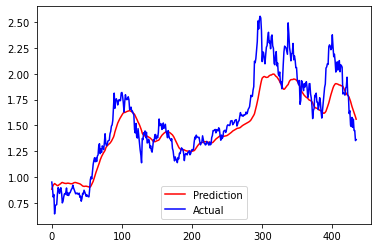

In [79]:
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(Ytest, color='blue', label='Actual')
plt.legend(loc='lower center')
plt.show()

By entering the date you will get prediction of next day of entered date

In [110]:
PredictStockPrice(loaded_model , data , '2022-05-23')

761.43005